In [88]:
%matplotlib inline
import numpy as np
import pandas as pd
import transformations as tf
import matplotlib.pyplot as plt
import pcl
import os
import os.path as osp

In [172]:
BASE_PATH = './data/tree2/test'
keyframes = pd.read_csv(osp.join(BASE_PATH, 'keyframes_with_id.txt'), sep=' ')
objects = pd.read_csv(osp.join(BASE_PATH,'objects.txt'), sep=' ')

In [173]:
# Loaded as XYZ pointclouds
map_cloud = pcl.load(osp.join(BASE_PATH, 'map.pcd'))
# object clouds
obj_clouds = {}
for i in objects['#id']:
    obj_clouds[i] = pcl.load(osp.join(BASE_PATH, 'object_pointclouds', '{}.pcd'.format(i)))

In [174]:
obj_clouds.keys()

dict_keys([0, 1])

In [175]:
def _get_tf_mat_from_row(drow):
    q = np.array(drow[['qw', 'qx', 'qy', 'qz']])
    t = np.array(drow[['x', 'y', 'z']]).reshape(3)
    T = tf.quaternion_matrix(q)
    T[:3, 3] = t
    return T

def add_tf_mat_to_df(df):
    df['T'] = df.apply(_get_tf_mat_from_row, axis=1)

def transform_cloud(T, points):
    points_homo = np.ones((points.shape[0], 4))
    points_homo[:,:3] = points
    points_homo = np.transpose(points_homo)
    outs = np.matmul(T, points_homo)
    return np.transpose(outs)[:, :3]

# Transform all points to local
def get_local_points(Two, points):
    Tow = np.linalg.inv(Two)
    points_homo = np.ones((points.shape[0], 4))
    points_homo[:,:3] = points
    points_homo = np.transpose(points_homo)
    outs = np.matmul(Tow, points_homo)
    return np.transpose(outs)[:, :3]

In [176]:
add_tf_mat_to_df(keyframes)
add_tf_mat_to_df(objects)

In [177]:
def get_value_by_id(df, id, col_name):
    return objects[objects['#id'] == id][col_name][0]

def get_row_by_id(df, id):
    return objects[objects['#id'] == id].iloc[0]

In [178]:
# TODO -- validate, seems not working
def add_tf_to_ref(data, ref_id=0):
    Tw_ref = data[data['#id'] == ref_id]['T'][0]
    Tref_w = np.linalg.inv(Tw_ref)
    refcol = 'T_ref{}'.format(ref_id)
    def _tmp_new_tf(row):
        if row['#id'] == ref_id:
            return np.eye(4)
        else:
            return Tref_w * row['T']
    data[refcol] = data.apply(_tmp_new_tf, axis=1)

In [179]:
add_tf_to_ref(objects)

In [180]:
# Transform mappoints to first object (id=0) frame ref
Tw0 = objects[objects['#id'] == 0]['T'][0]
map_cloud_0 = pcl.PointCloud(get_local_points(Tw0, np.asarray(map_cloud)).astype(np.float32))

In [189]:
pcl.save(map_cloud_0, 'world.pcd')

In [182]:
def _get_cloud_in_box(cloud, size_xy, height_min, height_max, origin):
    # TODO -- fix this using numpy all
    out = cloud

    # Filter X
    out = out[ out[:, 0] >= origin[0] - size_xy[0]]
    out = out[ out[:, 0] <= origin[0] + size_xy[0]]

    # Filter Y
    out = out[ out[:, 1] >= origin[1] - size_xy[1]]
    out = out[ out[:, 1] <= origin[1] + size_xy[1]]

    # Filter Height
    out = out[ out[:, 2] >= origin[2] - height_min ]
    out = out[ out[:, 2] <= origin[2] + height_max ]

    return out

# # TODO -- fix this!
# def get_tree_cloud_in_objects(map_cloud, objects, height=5.0, height_min=0.5, size_xy=None):
#     outcloud = {}
#     map_cloud_raw = np.asarray(map_cloud)
#     if size_xy is not None:
#         assert(len(size_xy) == 2)
    
#     for i in objects['#id']:
#         s_size = [0,0]
#         obj = get_row_by_id(objects, i)
#         T_ref0 = obj['T_ref0']
#         t = T_ref0[:3, 3] # centroid
#         print(t)
#         if size_xy is None:
#             s_size[0] = obj['sx']
#             s_size[1] = obj['sy']
#         else:
#             s_size = size_xy
        
#         tmp_cloud = _get_cloud_in_box(map_cloud_raw, size_xy, height_min, height, t)

#         outcloud[i] = pcl.PointCloud(tmp_cloud.astype(np.float32))

#     return outcloud

In [183]:
# get from world
def naive_get_tree_cloud_in_objects(map_cloud, objects, height=5.0, height_min=0.5, size_xy=None):
    outcloud = {}
    map_cloud_raw = np.asarray(map_cloud)
    if size_xy is not None:
        assert(len(size_xy) == 2)
    
    for i in objects['#id']:
        s_size = [0,0]
        obj = get_row_by_id(objects, i)
        T_ref0 = obj['T']
        t = (0,0,0) # centroid
        print(t)
        if size_xy is None:
            s_size[0] = obj['sx']
            s_size[1] = obj['sy']
        else:
            s_size = size_xy
        map_cloud_local = get_local_points(T_ref0, map_cloud_raw)
        tmp_cloud = _get_cloud_in_box(map_cloud_local, size_xy, height_min, height, t)

        outcloud[i] = pcl.PointCloud(tmp_cloud.astype(np.float32))

    return outcloud

In [184]:
def reconstruct_world_cloud(tree_clouds, objects, ref_id=None):
    out = []
    for i, cloud in tree_clouds.items():
        obj = get_row_by_id(objects, i)
        icloud = transform_cloud(obj['T'], np.asarray(cloud))
        out.append(icloud)
    
    outcloud = np.concatenate(out, axis=0)

    if ref_id is None:
        return pcl.PointCloud(outcloud.astype(np.float32))

    ref_obj = get_row_by_id(objects, ref_id)
    refcloud = get_local_points(ref_obj['T'], outcloud)

    return pcl.PointCloud(refcloud.astype(np.float32))

In [197]:
# DO NOT USE map_cloud_0, use world
out = naive_get_tree_cloud_in_objects(map_cloud, objects, size_xy=(2,2), height_min=0.1)
print(out)
recon = reconstruct_world_cloud(out, objects, ref_id=0)
pcl.save(recon, 'recon.pcd')

(0, 0, 0)
(0, 0, 0)
{0: <PointCloud of 837 points>, 1: <PointCloud of 778 points>}


In [191]:
719+102

821

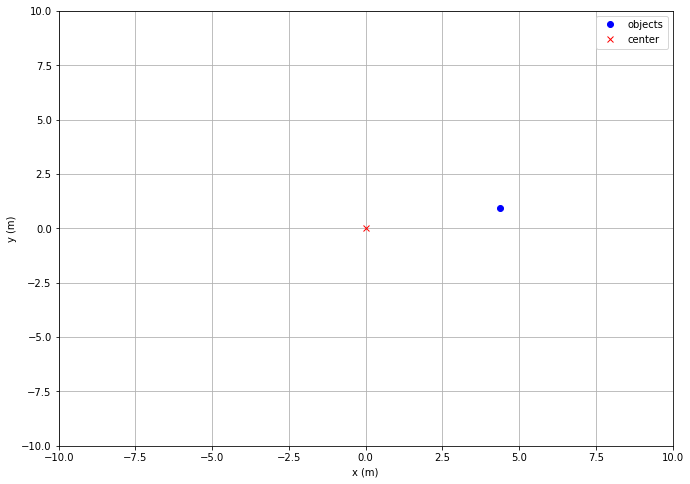

In [139]:
T1 = get_row_by_id(objects, 1)
plt.figure(figsize=(11,8))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.xlim((-10,10))
plt.ylim((-10,10))
plt.grid(True)
# Draw points
plt.plot(T1['T'][0,3], T1['T'][1,3], 'ro', color='b', label='objects')
plt.plot(0, 0, 'rx', color='r', label='center')
plt.legend()

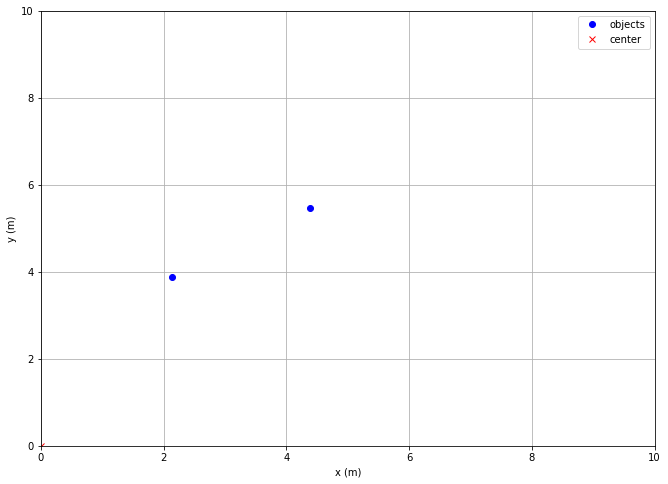

In [140]:
data0 = get_row_by_id(objects, 0)
data1 = get_row_by_id(objects, 1)
plt.figure(figsize=(11,8))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.xlim((0,10))
plt.ylim((0,10))
plt.grid(True)
# Draw points
plt.plot([data0['x'], data1['x']], [data0['z'], data1['z']], 'ro', color='b', label='objects')
plt.plot(0, 0, 'rx', color='r', label='center')
plt.legend()

In [64]:
x = np.transpose(np.array([ [1, 2, 3], [4, 5, 6], [7,8,9]]))

In [129]:
objects

,#id,label,x,y,z,qx,qy,qz,qw,sx,sy,sz,T,T_ref0
0,0,0,2.137294,0.601331,3.877034,0.584839,-0.324283,0.396349,0.629056,0.431192,0.479107,0.087841,"[[0.47549606516709875, -0.8779580353347702, 0....","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..."
1,1,0,4.381115,0.915378,5.465585,0.601855,-0.291490,0.361005,0.649984,0.666446,0.372832,0.098058,"[[0.569417798263272, -0.8201646452411815, 0.05...","[[0.2707559225102987, -0.09788232827841803, 0...."


In [122]:
tf.transformations.inverse_matrix(objects['T_ref0'].iloc[1])[:, 3]

array([ 77.67544699,   6.5171438 , -16.95360563,   1.        ])

In [130]:
dir(tf.transformations)

['Arcball',
 '_AXES2TUPLE',
 '_EPS',
 '_NEXT_AXIS',
 '_TUPLE2AXES',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__docformat__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__version__',
 '_import_module',
 'affine_matrix_from_points',
 'angle_between_vectors',
 'arcball_constrain_to_axis',
 'arcball_constrain_to_axis_py',
 'arcball_map_to_sphere',
 'arcball_map_to_sphere_py',
 'arcball_nearest_axis',
 'clip_matrix',
 'clip_matrix_py',
 'compose_matrix',
 'concatenate_matrices',
 'decompose_matrix',
 'division',
 'euler_from_matrix',
 'euler_from_matrix_py',
 'euler_from_quaternion',
 'euler_matrix',
 'euler_matrix_py',
 'identity_matrix',
 'identity_matrix_py',
 'inverse_matrix',
 'inverse_matrix_py',
 'is_same_quaternion',
 'is_same_transform',
 'is_same_transform_py',
 'math',
 'numpy',
 'orthogonalization_matrix',
 'orthogonalization_matrix_py',
 'print_function',
 'projection_from_matrix',
 'projection_matrix',
 'projection_matrix_py',
 'quaternion_abo

In [131]:
tf.transformations.translation_from_matrix(objects['T_ref0'].iloc[1])

array([-1.95713391e+01,  1.77010514e-02,  3.75587035e-01])